# Machine Learning for Bulldozer Prices

In this notebook, our objective is to develop a machine learning model that predicts the sale price of bulldozers. This task falls under the category of **regression** problems, as we aim to forecast a numerical value.

The dataset we'll be working with and the evaluation metric, root mean square log error (RMSLE), are sourced from **the Kaggle Bluebook for Bulldozers competition**.

## 1. Problem Definition
The main question we're tackling with this dataset is:
> To predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.

## 2. Data
The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

- **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the target variable).
- **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as Train.csv).
- **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation
The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note**: The goal for most regression evaluation metrics is to minimize the error. *For example*, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features
Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
# Loading the tools required 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

> We specifically choose `RandomForestRegressor` for predicting auction sale prices of heavy equipment like bulldozers because it's flexible, handles non-linear relationships well, deals with missing values and outliers effectively, provides feature importance, performs decently without much tuning, and scales reasonably for medium-sized datasets. Overall, it's a reliable and versatile choice for this type of predictive modeling task.

In [2]:
# Import the training and validation set
df = pd.read_csv("/kaggle/input/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)
df_dup = df.copy()
df

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6333344,10000.0,1919201,21435,149,2.0,2005,NaN,NaN,3/7/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412694,6333345,10500.0,1882122,21436,149,2.0,2005,NaN,NaN,1/28/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412695,6333347,12500.0,1944213,21435,149,2.0,2005,NaN,NaN,1/28/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412696,6333348,10000.0,1794518,21435,149,2.0,2006,NaN,NaN,3/7/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

> There is an important feature called `saledate` that we see is in `object` format, but it should be in `datetime64` format. Therefore, we need to change its type.

In [4]:
df['saledate'] = pd.to_datetime(df['saledate'])

In [5]:
df['saledate']

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

> Additionally, we can provide separate features for the day, month, and year extracted from `saledate` to make the dataset more manageable and enhance its usability. This can facilitate easier analysis and modeling by providing additional temporal information for each sale.

In [6]:
df['saleday'] = df['saledate'].dt.day
df['salemonth'] = df['saledate'].dt.month
df['saleyear'] = df['saledate'].dt.year

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 56 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [8]:
# Now we can drop `saledate` from dataset. Not to worry, we already have a duplicate for our dataset `df_dup`
df.drop('saledate', axis=1, inplace=True)

In [9]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
fiModelDesc,521D,950FII,226,PC120-6E,S175


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 55 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

> Now that we've converted `saledate` to `datetime64` format, we still have 44 features with `object` type. This indicates a large number of columns containing non-numeric data types, such as strings or categorical variables. To address this, we need to **convert these non-numeric features to numeric format.**

In [11]:
pd.api.types.is_string_dtype(df['UsageBand'])

False

In [12]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

fiModelDesc
fiBaseModel
fiProductClassDesc
state
ProductGroup
ProductGroupDesc


In [13]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype('category').cat.as_ordered()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 55 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   object  
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  object  
 12  fiModelSeries             58667 non-null   object  
 13  fiModelDescriptor         748

In [15]:
for label, content in df.items():
    if pd.api.types.is_object_dtype(content):
        df[label] = content.astype('category').cat.as_ordered()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 55 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [17]:
df['state'].cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [18]:
df['state'].cat.codes

0          0
1         32
2         31
3         43
4         31
          ..
412693    43
412694     8
412695     8
412696    43
412697     8
Length: 412698, dtype: int8

> We have separate training and validation sets provided to us, which is excellent. However, it's a good practice to split our `TrainAndValid` dataset into training and validation sets as well.

> But why split the data before resolving missing values? The goal of machine learning is to use past data to predict the future. If our validation set is supposed to represent the future, we shouldn't manipulate our training data using information from the validation set. Think of the training data as representing the past and the validation data as representing the present.

In [19]:
# Split data into training and validation
df_train = df[df['saleyear'] != 2012]
df_val = df[df['saleyear'] == 2012]

len(df_train), len(df_val)

(401125, 11573)

> **`SalePrice` is the Target feature.**

In [20]:
# Let's find out the percentage of missing values in each feature
(df.isna().sum()/len(df))*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

> In our dataset, we've noticed a significant amount of missing data, which could pose a serious challenge. While dropping features with too many missing values is a common strategy, we'll refrain from doing so for now. Before making such decisions, consulting domain experts is crucial to understand the reasons behind the missing data and whether dropping or imputing them would be appropriate.

> For the time being, our focus will be on converting categorical features to numerical ones and handling missing values. We'll fill the missing values with the median, which is a simple yet effective imputation strategy. This will allow us to retain as much information as possible while preparing the data for further analysis and modeling.

> Let's proceed with these steps to ensure our dataset is ready for exploration and modeling.

In [21]:
# Fill numerical missing values in `df_train`

for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_train[label+"_is_missing"] = pd.isnull(content)
            df_train[label] = content.fillna(content.median())

In [22]:
df_train.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              331486
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        137191
fiModelSeries                          344217
fiModelDescriptor                      329206
ProductSize                            210775
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           296764
Enclosure                                 325
Forks                             

In [23]:
# Fill numerical missing values in `df_valid`

for label, content in df_val.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_val[label+"_is_missing"] = pd.isnull(content)
            df_val[label] = content.fillna(content.median())

In [24]:
df_val.isna().sum()

SalesID                                    0
SalePrice                                  0
MachineID                                  0
ModelID                                    0
datasource                                 0
auctioneerID                               0
YearMade                                   0
MachineHoursCurrentMeter                   0
UsageBand                               7542
fiModelDesc                                0
fiBaseModel                                0
fiSecondaryDesc                         3536
fiModelSeries                           9814
fiModelDescriptor                       8676
ProductSize                             5830
fiProductClassDesc                         0
state                                      0
ProductGroup                               0
ProductGroupDesc                           0
Drive_System                            8847
Enclosure                                  9
Forks                                   5935
Pad_Type  

In [25]:
df_train['age'] = df_train['saleyear'] - df_train['YearMade']
df_val['age'] = df_val['saleyear'] - df_val['YearMade']

In [26]:
df_train.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
fiModelDesc,521D,950FII,226,PC120-6E,S175


In [27]:
df_val.head().T

,401125,401126,401127,401128,401129
SalesID,1222837,1222839,1222841,1222843,1222845
SalePrice,31000.0,54000.0,26500.0,10000.0,35000.0
MachineID,902859,1048320,999308,1062425,1032841
ModelID,1376,36526,4587,1954,4701
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,1000,2006,2000,1000,2002
MachineHoursCurrentMeter,0.0,4412.0,10127.0,4682.0,8150.0
UsageBand,NaN,Medium,Medium,Low,Medium
fiModelDesc,375L,TX300LC2,270LC,892DLC,544H


### Visualizations

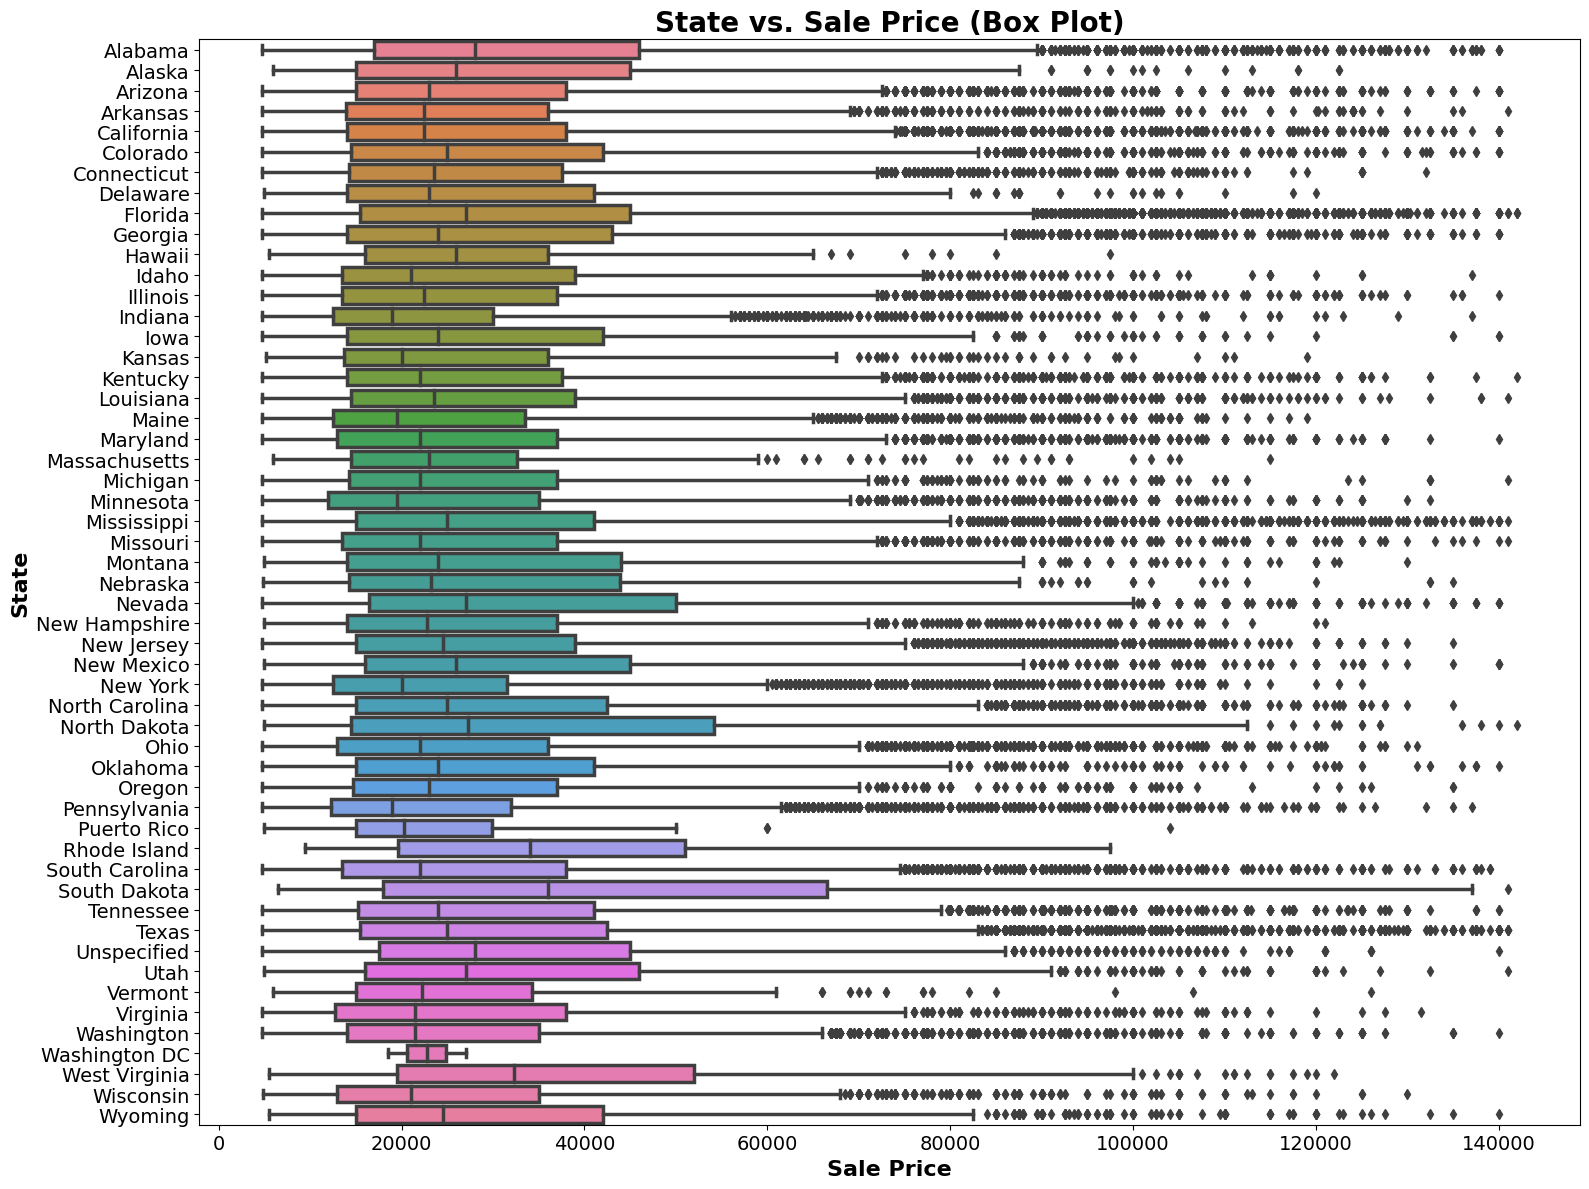

In [28]:
plt.figure(figsize=(16, 12))
custom_palette = sns.color_palette("husl", n_colors=len(df_train['state'].unique()))
sns.boxplot(x='SalePrice', y='state', data=df_train, orient='h', palette=custom_palette, linewidth=2.5)
plt.title("State vs. Sale Price (Box Plot)", fontsize=20, fontweight='bold')
plt.xlabel('Sale Price', fontsize=16, fontweight='bold')
plt.ylabel('State', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

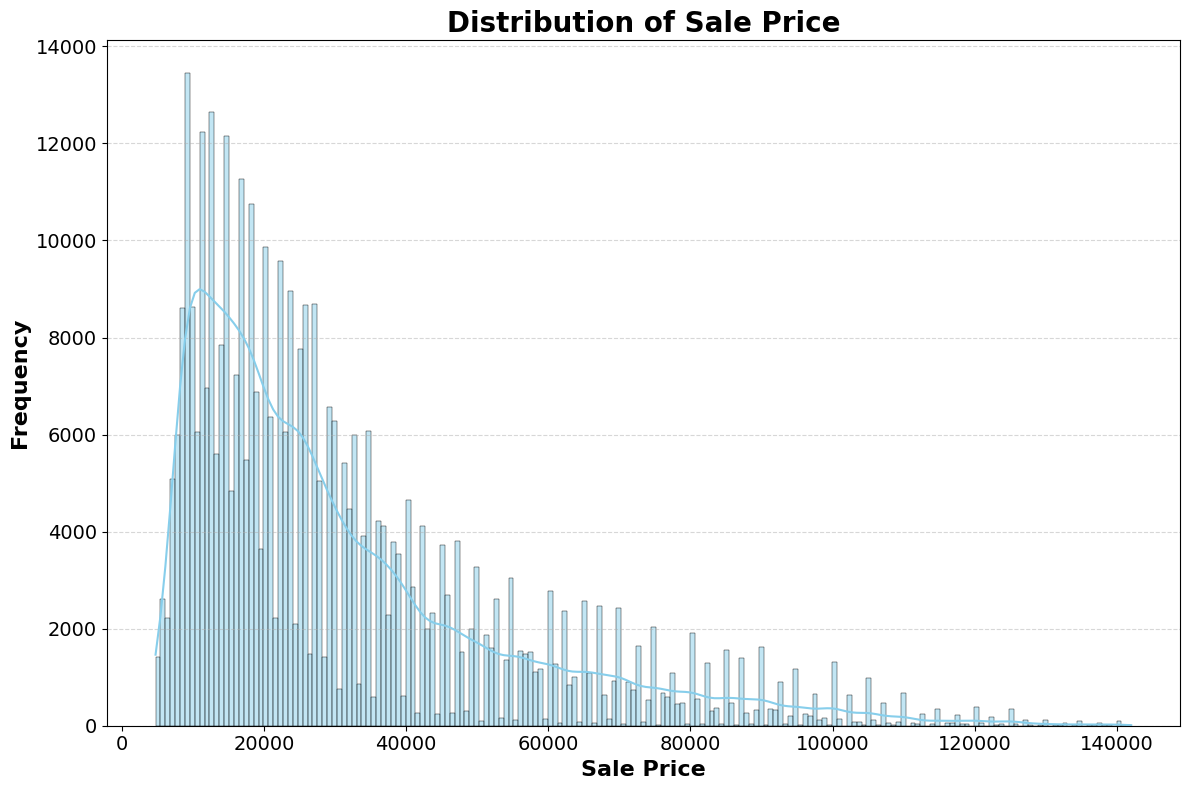

In [29]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df_train, x='SalePrice', kde=True, color='skyblue' )
plt.title("Distribution of Sale Price", fontsize=20, fontweight='bold')
plt.xlabel('Sale Price', fontsize=16, fontweight='bold')
plt.ylabel('Frequency', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

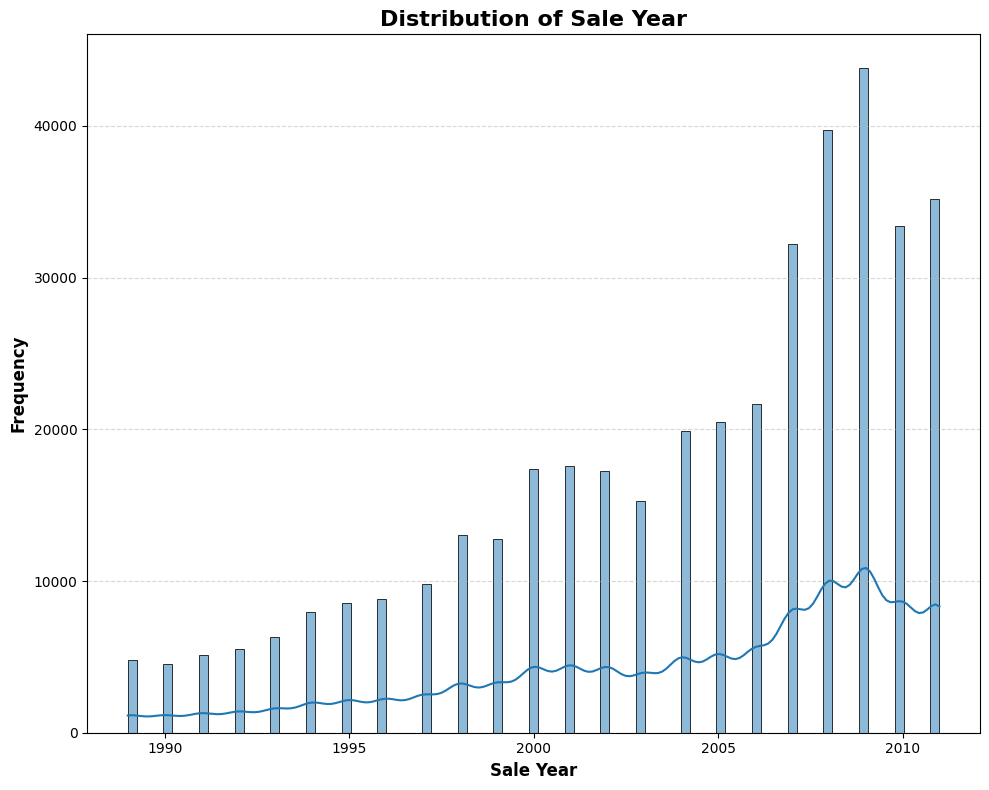

In [30]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_train, x='saleyear', kde=True)
plt.title("Distribution of Sale Year", fontsize=16, fontweight='bold')
plt.xlabel('Sale Year', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

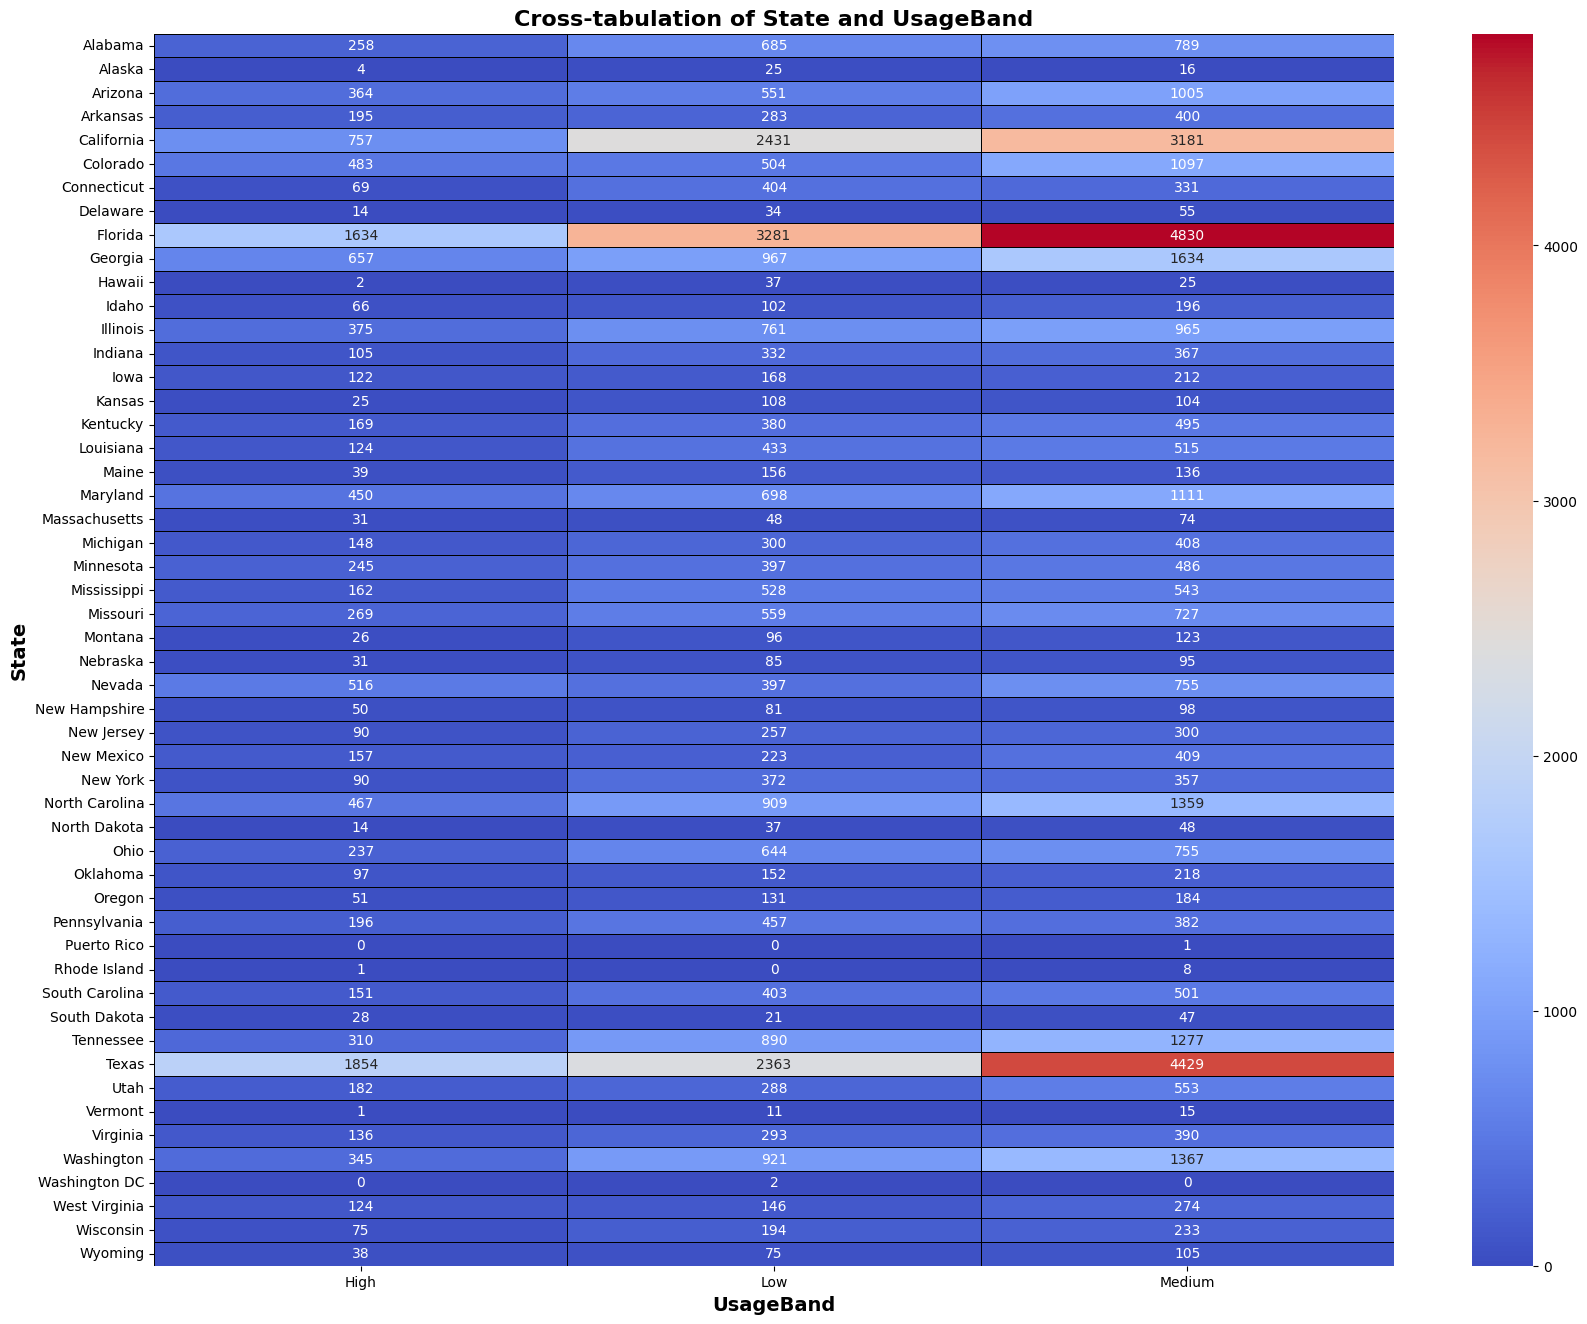

In [31]:
cross_tab = pd.crosstab(df_train['state'], df_train['UsageBand'])

# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(cross_tab, cmap='coolwarm', annot=True, fmt='d', cbar=True, linewidths=0.5, linecolor='black')
plt.xlabel('UsageBand', fontsize=14, fontweight='bold')
plt.ylabel('State', fontsize=14, fontweight='bold')
plt.title('Cross-tabulation of State and UsageBand', fontsize=16, fontweight='bold')
plt.show()

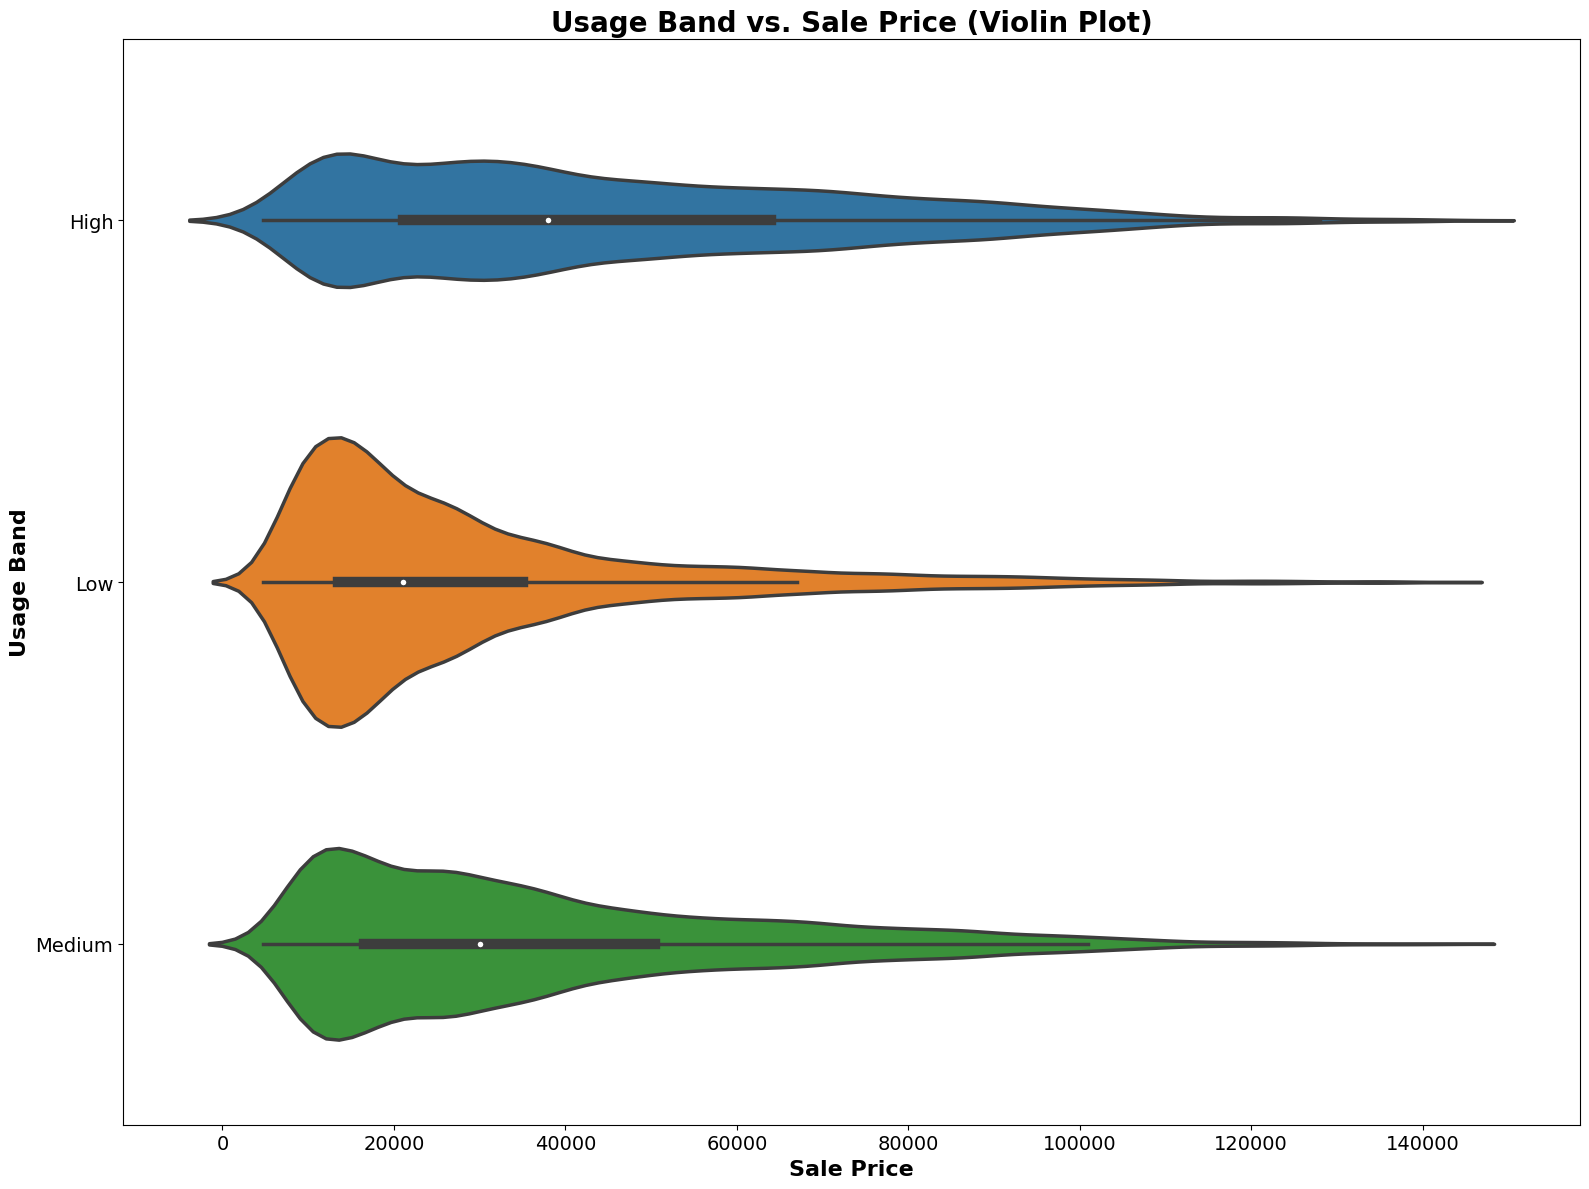

In [32]:
plt.figure(figsize=(16, 12))
sns.violinplot(x='SalePrice', y='UsageBand', data=df_train, orient='h', linewidth=2.5)
plt.title("Usage Band vs. Sale Price (Violin Plot)", fontsize=20, fontweight='bold')
plt.xlabel('Sale Price', fontsize=16, fontweight='bold')
plt.ylabel('Usage Band', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

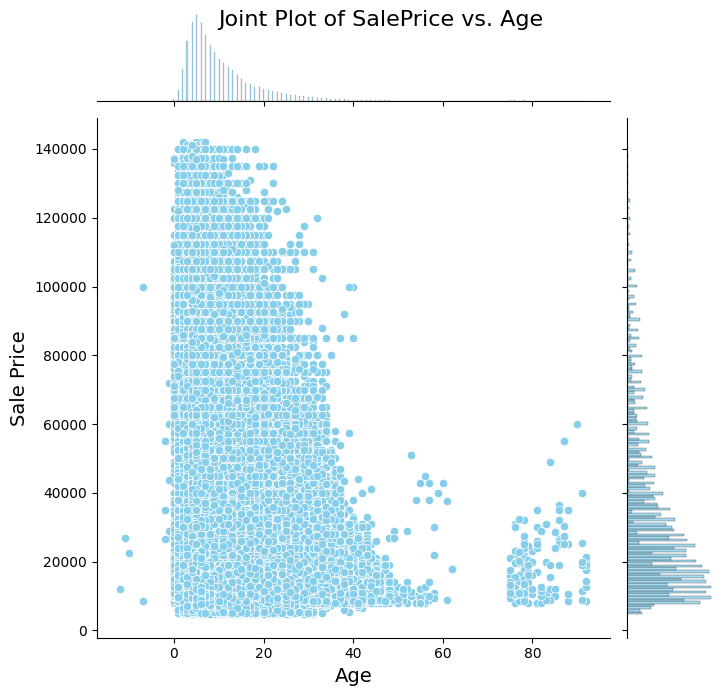

In [33]:
filtered_df = df_train[df_train['age'] < 200]
sns.jointplot(data=filtered_df, x='age', y='SalePrice', kind='scatter', color='skyblue',height=7, ratio=5)
plt.suptitle('Joint Plot of SalePrice vs. Age', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Sale Price', fontsize=14)
plt.show()

In [34]:
# Filling and turning categorical variables into numbers in df_train

for label, content in df_train.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_train[label+'is_missing'] = pd.isnull(content)
        df_train[label] = pd.Categorical(content).codes+1

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 0 to 401124
Columns: 102 entries, SalesID to Steering_Controlsis_missing
dtypes: bool(46), float64(3), int16(4), int32(3), int64(6), int8(40)
memory usage: 71.2 MB


In [36]:
df_train['auctioneerID_is_missing'].value_counts()

auctioneerID_is_missing
False    380989
True      20136
Name: count, dtype: int64

In [37]:
df_train.drop('auctioneerID_is_missing', axis=1, inplace=True)

In [38]:
for label, content in df_val.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_val[label+"is_missing"] = pd.isnull(content)
        df_val[label] = pd.Categorical(content).codes+1

In [39]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11573 entries, 401125 to 412697
Columns: 101 entries, SalesID to Steering_Controlsis_missing
dtypes: bool(45), float64(3), int16(4), int32(3), int64(6), int8(40)
memory usage: 2.0 MB


In [40]:
X_train, y_train = (df_train.drop('SalePrice', axis=1), df_train['SalePrice'])
X_valid, y_valid = (df_val.drop('SalePrice', axis=1), df_val['SalePrice'])

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((401125, 100), (11573, 100), (401125,), (11573,))

### Building an evaluation function

In [41]:
# Create evaluation function (the competition uses RMSLE)

def rmsle(y_true, y_preds):
    return np.sqrt(mean_squared_log_error(y_true, y_preds))

In [42]:
# Create function to evaluate model on a few different levels

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {
        "Training MAE" : mean_absolute_error(y_train, train_preds),
        "Validation MAE" : mean_absolute_error(y_valid, val_preds),
        "Training RMSLE" : rmsle(y_train, train_preds),
        "Validation RMSLE" : rmsle(y_valid, val_preds),
        "Training R2-Squared" : r2_score(y_train, train_preds),
        "Validation R2-Squared" : r2_score(y_valid, val_preds)
    }
    return scores

In [43]:
# Experimentation with our model, using only 10K samples instead of 40K to save the time

model = RandomForestRegressor(n_jobs=-1,
                              random_state=5,
                              max_samples=10000)

In [44]:
model.fit(X_train, y_train)

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=5)

In [45]:
show_scores(model)

{'Training MAE': 5466.641476322842,
 'Validation MAE': 7332.372524842306,
 'Training RMSLE': 0.2536308704394553,
 'Validation RMSLE': 0.29124455895860374,
 'Training R2-Squared': 0.8659877094454396,
 'Validation R2-Squared': 0.8206375826934507}

### Hyperparameter Tuning with `RandomizedSearchCV`

> We initially use a minimal sample size for experimentation purposes. Using the entire dataset can be time-consuming. Therefore, it's often a good practice to experiment with different hyperparameters to find the best combination. Once we have identified the best hyperparameters, we can then utilize them with the actual dataset. This approach saves a significant amount of time and computational resources.

In [46]:
# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": [40, 100],
           "max_depth": [5, 10],
           "min_samples_split": [14,20],
           "min_samples_leaf": [1,3],
           "max_features": [0.5, "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=5),
                              param_distributions=rf_grid,
                              n_iter=5,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=5),
                   n_iter=5,
                   param_distributions={'max_depth': [5, 10],
                                        'max_features': [0.5, 'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': [1, 3],
                                        'min_samples_split': [14, 20],
                                        'n_estimators': [40, 100]},
                   verbose=True)

In [47]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 14,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': 10}

In [48]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 6345.134993680223,
 'Validation MAE': 8206.845566859209,
 'Training RMSLE': 0.2894192271047215,
 'Validation RMSLE': 0.3193769629125525,
 'Training R2-Squared': 0.8271440078048928,
 'Validation R2-Squared': 0.7783644875806539}

### Train a model with the best hyperparamters

**Note:** These were found after 100 iterations of `RandomizedSearchCV` done by Daniel in the ZTM course, and I took the hyperparameters from his notes.

In [49]:
# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=5) 
# Fit the ideal model
ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=5)

In [50]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2967.9079828219283,
 'Validation MAE': 6177.6415032145,
 'Training RMSLE': 0.14540660106834546,
 'Validation RMSLE': 0.24871158284392988,
 'Training R2-Squared': 0.9586110989432433,
 'Validation R2-Squared': 0.8705541759419813}

### Make predictions on test data

In [51]:
# Import the test data
df_test = pd.read_csv('/kaggle/input/bluebook-for-bulldozers/Test.csv', low_memory=False, parse_dates=['saledate'])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [52]:
df_test.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,1999,1000,2004,2006,2005
MachineHoursCurrentMeter,3688.0,28555.0,6038.0,8940.0,2286.0
UsageBand,Low,High,Medium,High,Low
saledate,2012-05-03 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00
fiModelDesc,580G,936,EC210BLC,330CL,650K


### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [53]:
def preprocess_data(df):
    df['saleday'] = df['saledate'].dt.day
    df['salemonth'] = df['saledate'].dt.month
    df['saleyear'] = df['saledate'].dt.year
    
    df.drop('saledate', axis=1, inplace=True)
    
    for label, content in df.items():
        if pd.api.types.is_object_dtype(content):
            df[label] = content.astype('category').cat.as_ordered()
        
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        if not pd.api.types.is_numeric_dtype(content):
            df[label+'is_missing'] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes+1
            
    return df

In [54]:
# Process the test data 
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Widthis_missing,Stick_Lengthis_missing,Thumbis_missing,Pattern_Changeris_missing,Grouser_Typeis_missing,Backhoe_Mountingis_missing,Blade_Typeis_missing,Travel_Controlsis_missing,Differential_Typeis_missing,Steering_Controlsis_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [55]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 99 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   SalesID                              12457 non-null  int64  
 1   MachineID                            12457 non-null  int64  
 2   ModelID                              12457 non-null  int64  
 3   datasource                           12457 non-null  int64  
 4   auctioneerID                         12457 non-null  int64  
 5   YearMade                             12457 non-null  int64  
 6   MachineHoursCurrentMeter             12457 non-null  float64
 7   UsageBand                            12457 non-null  int8   
 8   fiModelDesc                          12457 non-null  int16  
 9   fiBaseModel                          12457 non-null  int16  
 10  fiSecondaryDesc                      12457 non-null  int8   
 11  fiModelSeries               

In [56]:
set(df_train.columns) - set(df_test)

{'SalePrice', 'age'}

> I forgot to add 'age' as we added an extra column called 'age' in X_train. Now, we have to add 'age' to X_test. After adding 'age', we still have to reorder it, as 'age' should come last among the columns. Therefore, we need to change its position to the 55th position in X_test, similar to X_train.

In [57]:
df_test['age'] = df_test['saleyear'] - df_test['YearMade']

In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 0 to 401124
Data columns (total 100 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   SalesID                              401125 non-null  int64  
 1   MachineID                            401125 non-null  int64  
 2   ModelID                              401125 non-null  int64  
 3   datasource                           401125 non-null  int64  
 4   auctioneerID                         401125 non-null  float64
 5   YearMade                             401125 non-null  int64  
 6   MachineHoursCurrentMeter             401125 non-null  float64
 7   UsageBand                            401125 non-null  int8   
 8   fiModelDesc                          401125 non-null  int16  
 9   fiBaseModel                          401125 non-null  int16  
 10  fiSecondaryDesc                      401125 non-null  int16  
 11  fiModelSeries    

In [59]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 100 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   SalesID                              12457 non-null  int64  
 1   MachineID                            12457 non-null  int64  
 2   ModelID                              12457 non-null  int64  
 3   datasource                           12457 non-null  int64  
 4   auctioneerID                         12457 non-null  int64  
 5   YearMade                             12457 non-null  int64  
 6   MachineHoursCurrentMeter             12457 non-null  float64
 7   UsageBand                            12457 non-null  int8   
 8   fiModelDesc                          12457 non-null  int16  
 9   fiBaseModel                          12457 non-null  int16  
 10  fiSecondaryDesc                      12457 non-null  int8   
 11  fiModelSeries              

In [60]:
columns = df_test.columns.tolist()
age_index = columns.index('age')
columns.remove('age')
columns.insert(55, 'age')
df_test = df_test[columns]

In [61]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 100 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   SalesID                              12457 non-null  int64  
 1   MachineID                            12457 non-null  int64  
 2   ModelID                              12457 non-null  int64  
 3   datasource                           12457 non-null  int64  
 4   auctioneerID                         12457 non-null  int64  
 5   YearMade                             12457 non-null  int64  
 6   MachineHoursCurrentMeter             12457 non-null  float64
 7   UsageBand                            12457 non-null  int8   
 8   fiModelDesc                          12457 non-null  int16  
 9   fiBaseModel                          12457 non-null  int16  
 10  fiSecondaryDesc                      12457 non-null  int8   
 11  fiModelSeries              

In [62]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)
test_preds

array([19173.22229898, 15394.66871777, 47325.62772523, ...,
       14681.5590279 , 17587.89375281, 27995.41347513])

In [63]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,19173.222299
1,1227844,15394.668718
2,1227847,47325.627725
3,1227848,74740.330646
4,1227863,60400.887425
...,...,...
12452,6643171,38932.375939
12453,6643173,13235.916380
12454,6643184,14681.559028
12455,6643186,17587.893753


In [64]:
# Export prediction data
df_preds.to_csv("/kaggle/working/test_predictions.csv", index=False)

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the target variable (SalePrice).

In [65]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([2.10835483e-02, 1.13796544e-02, 4.54009534e-02, 9.76168895e-04,
       3.43650136e-03, 8.96240181e-02, 2.59064029e-03, 9.66301620e-04,
       4.34637963e-02, 5.13458073e-02, 5.82738559e-02, 4.18198013e-03,
       1.13634250e-02, 1.69968652e-01, 4.42530524e-02, 6.40610097e-03,
       5.78266170e-03, 3.32044920e-03, 2.93146747e-03, 5.67535004e-02,
       5.28495383e-04, 6.02963973e-05, 9.47765601e-04, 2.63392335e-04,
       1.03349304e-03, 2.99057043e-05, 6.22365987e-04, 1.02770257e-02,
       5.52401217e-04, 6.69935030e-04, 5.75768739e-03, 1.70803830e-03,
       6.43340783e-03, 7.46853916e-04, 4.67697888e-03, 9.36882631e-03,
       1.26636049e-03, 1.00538229e-02, 2.70440544e-03, 4.08248304e-03,
       1.36355099e-03, 7.51985608e-04, 3.60552566e-03, 5.91301583e-04,
       2.36473236e-04, 3.81524209e-04, 1.65086146e-03, 1.56236933e-03,
       1.09660278e-03, 1.68469990e-04, 3.53733684e-04, 6.22410245e-03,
       8.06412557e-03, 2.15266312e-02, 6.78492994e-04, 1.76630789e-01,
      

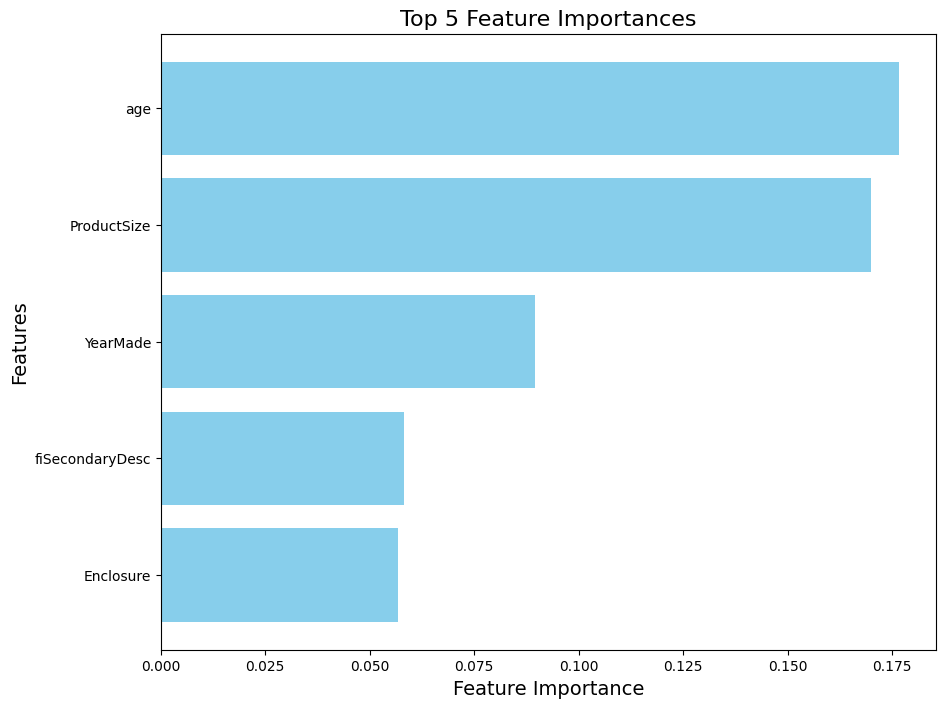

In [66]:
def plot_features(columns, importances):
    df = (pd.DataFrame({"features": columns, "feature_importances": importances})
                        .sort_values("feature_importances", ascending=False)
                        .reset_index(drop=True))
    
    # Plot the dataframe
    plt.figure(figsize=(10, 8))
    plt.barh(df["features"][:5], df["feature_importances"][:5], color='skyblue')
    
    # Title and Labels
    plt.title('Top 5 Feature Importances', fontsize=16)
    plt.xlabel('Feature Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.gca().invert_yaxis()
    plt.show()

plot_features(X_train.columns, ideal_model.feature_importances_)